In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
 
import torch
import torch.nn as nn
import torch.optim as optim

from utils import seed
from data import dataset
from model.backbone import VGG16, ResNet34
from model.simclr import basic_simclr, data_aug, simclr_train
from model import basic_classifier
from utils import train

seed.seed_everything()

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# VGG

## SimCLR

In [3]:
path = './data'

dataset_simclr = data_aug.ContrastiveLearningDataset(path=path, input_shape=96)

batch_size = 256

train_set = dataset_simclr.get_dataset()
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=0,
                                           pin_memory=True, 
                                           drop_last=True)

In [4]:
backbone = VGG16.VGG16_Backbone(pretrain=False).to(device=device)
model = basic_simclr.BasicSimCLR(backbone, num_classes=64).to(device=device)

print(model)

BasicSimCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [5]:
# default hyperparameters
lr = 3e-4
weight_decay = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=len(train_loader), 
                                                       eta_min=0,
                                                       last_epoch=-1)

In [6]:
simclr = simclr_train.SimCLR(model=model,
                             model_name='VGG16',
                             scheduler=scheduler,
                             optimizer=optimizer,
                             device=device,
                             epochs=100)

In [7]:
simclr.train(train_loader=train_loader)

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [28:49<00:00,  1.69s/it]


## Model Train

In [21]:
# (already downloaded) dataset path 
path = './data'

train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=96,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=256,
                                                          seed=21)

In [22]:
backbone = VGG16.VGG16_Backbone(pretrain=False).to(device=device)
model_temp = basic_simclr.BasicSimCLR(backbone, num_classes=64).to(device=device)

# path - VGG 
log_dir = 'checkpoints/Mar30_11-40-32'
file_path = 'checkpoint_0100.pth.tar'

checkpoint_path = os.path.join(log_dir, file_path)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_temp.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [23]:
# backbone from SimCLR
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

print(model)

BasicClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0

In [24]:
EPOCHS = 50

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
es = train.EarlyStopping(patience=EPOCHS//2, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//5, gamma=0.9)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf    

In [25]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=scheduler, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_loss)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model_VGG_3.pth')
    
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:44<00:00,  1.75it/s]


[EarlyStopping] (Update) Best Score: 0.53238
[INFO] val_loss has been improved from inf to 0.53238. Save model.
epoch 01, loss: 0.49849, accuracy: 0.76076, val_loss: 0.53238, val_accuracy: 0.72806 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:26<00:00,  1.81it/s]


[EarlyStopping] (Update) Best Score: 0.49261
[INFO] val_loss has been improved from 0.53238 to 0.49261. Save model.
epoch 02, loss: 0.46439, accuracy: 0.78178, val_loss: 0.49261, val_accuracy: 0.76505 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.47641
[INFO] val_loss has been improved from 0.49261 to 0.47641. Save model.
epoch 03, loss: 0.45137, accuracy: 0.79050, val_loss: 0.47641, val_accuracy: 0.77100 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.47641, Current: 0.47908, Delta: 0.00267
epoch 04, loss: 0.44605, accuracy: 0.79376, val_loss: 0.47908, val_accuracy: 0.77084 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.47641, Current: 0.47794, Delta: 0.00153
epoch 05, loss: 0.44270, accuracy: 0.79622, val_loss: 0.47794, val_accuracy: 0.77194 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.45657
[INFO] val_loss has been improved from 0.47641 to 0.45657. Save model.
epoch 06, loss: 0.43939, accuracy: 0.79869, val_loss: 0.45657, val_accuracy: 0.77783 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.45657, Current: 0.47363, Delta: 0.01706
epoch 07, loss: 0.43835, accuracy: 0.79880, val_loss: 0.47363, val_accuracy: 0.77524 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.45657, Current: 0.47226, Delta: 0.01569
epoch 08, loss: 0.43594, accuracy: 0.80091, val_loss: 0.47226, val_accuracy: 0.77469 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.45657, Current: 0.47515, Delta: 0.01858
epoch 09, loss: 0.43580, accuracy: 0.80106, val_loss: 0.47515, val_accuracy: 0.77652 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.45088
[INFO] val_loss has been improved from 0.45657 to 0.45088. Save model.
epoch 10, loss: 0.43521, accuracy: 0.80117, val_loss: 0.45088, val_accuracy: 0.78143 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.45088, Current: 0.45953, Delta: 0.00865
epoch 11, loss: 0.43268, accuracy: 0.80215, val_loss: 0.45953, val_accuracy: 0.78226 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.45088, Current: 0.45480, Delta: 0.00392
epoch 12, loss: 0.43240, accuracy: 0.80333, val_loss: 0.45480, val_accuracy: 0.78214 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.45088, Current: 0.45383, Delta: 0.00295
epoch 13, loss: 0.43278, accuracy: 0.80246, val_loss: 0.45383, val_accuracy: 0.78293 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.87it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.45088, Current: 0.45840, Delta: 0.00752
epoch 14, loss: 0.43208, accuracy: 0.80341, val_loss: 0.45840, val_accuracy: 0.78024 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Update) Best Score: 0.44544
[INFO] val_loss has been improved from 0.45088 to 0.44544. Save model.
epoch 15, loss: 0.43108, accuracy: 0.80392, val_loss: 0.44544, val_accuracy: 0.78564 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.44544, Current: 0.45322, Delta: 0.00778
epoch 16, loss: 0.43206, accuracy: 0.80335, val_loss: 0.45322, val_accuracy: 0.78253 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.44544, Current: 0.45100, Delta: 0.00556
epoch 17, loss: 0.43084, accuracy: 0.80320, val_loss: 0.45100, val_accuracy: 0.78247 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.44544, Current: 0.46091, Delta: 0.01548
epoch 18, loss: 0.43157, accuracy: 0.80441, val_loss: 0.46091, val_accuracy: 0.78287 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.44544, Current: 0.46874, Delta: 0.02330
epoch 19, loss: 0.43160, accuracy: 0.80418, val_loss: 0.46874, val_accuracy: 0.77869 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.44544, Current: 0.45892, Delta: 0.01348
epoch 20, loss: 0.43072, accuracy: 0.80387, val_loss: 0.45892, val_accuracy: 0.78186 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.44544, Current: 0.45272, Delta: 0.00728
epoch 21, loss: 0.43001, accuracy: 0.80547, val_loss: 0.45272, val_accuracy: 0.78549 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 7/25, Best: 0.44544, Current: 0.45880, Delta: 0.01336
epoch 22, loss: 0.43046, accuracy: 0.80413, val_loss: 0.45880, val_accuracy: 0.78259 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:08<00:00,  1.87it/s]


[EarlyStopping] (Patience) 8/25, Best: 0.44544, Current: 0.46586, Delta: 0.02042
epoch 23, loss: 0.43015, accuracy: 0.80429, val_loss: 0.46586, val_accuracy: 0.77783 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 9/25, Best: 0.44544, Current: 0.45918, Delta: 0.01374
epoch 24, loss: 0.42928, accuracy: 0.80577, val_loss: 0.45918, val_accuracy: 0.78409 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:09<00:00,  1.86it/s]


[EarlyStopping] (Patience) 10/25, Best: 0.44544, Current: 0.45045, Delta: 0.00502
epoch 25, loss: 0.43013, accuracy: 0.80447, val_loss: 0.45045, val_accuracy: 0.78705 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 11/25, Best: 0.44544, Current: 0.45305, Delta: 0.00761
epoch 26, loss: 0.43024, accuracy: 0.80469, val_loss: 0.45305, val_accuracy: 0.78198 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 12/25, Best: 0.44544, Current: 0.44799, Delta: 0.00255
epoch 27, loss: 0.42971, accuracy: 0.80515, val_loss: 0.44799, val_accuracy: 0.78540 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 13/25, Best: 0.44544, Current: 0.44655, Delta: 0.00111
epoch 28, loss: 0.42927, accuracy: 0.80491, val_loss: 0.44655, val_accuracy: 0.78705 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 14/25, Best: 0.44544, Current: 0.45115, Delta: 0.00572
epoch 29, loss: 0.42971, accuracy: 0.80507, val_loss: 0.45115, val_accuracy: 0.78427 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 15/25, Best: 0.44544, Current: 0.45415, Delta: 0.00872
epoch 30, loss: 0.43019, accuracy: 0.80434, val_loss: 0.45415, val_accuracy: 0.78268 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 16/25, Best: 0.44544, Current: 0.45234, Delta: 0.00690
epoch 31, loss: 0.42804, accuracy: 0.80556, val_loss: 0.45234, val_accuracy: 0.78564 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 17/25, Best: 0.44544, Current: 0.45970, Delta: 0.01426
epoch 32, loss: 0.42882, accuracy: 0.80544, val_loss: 0.45970, val_accuracy: 0.78476 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 18/25, Best: 0.44544, Current: 0.45420, Delta: 0.00876
epoch 33, loss: 0.42807, accuracy: 0.80558, val_loss: 0.45420, val_accuracy: 0.78546 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:15<00:00,  1.84it/s]


[EarlyStopping] (Patience) 19/25, Best: 0.44544, Current: 0.44643, Delta: 0.00099
epoch 34, loss: 0.42759, accuracy: 0.80658, val_loss: 0.44643, val_accuracy: 0.78464 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:33<00:00,  1.78it/s]


[EarlyStopping] (Update) Best Score: 0.44232
[INFO] val_loss has been improved from 0.44544 to 0.44232. Save model.
epoch 35, loss: 0.42842, accuracy: 0.80582, val_loss: 0.44232, val_accuracy: 0.78973 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.44232, Current: 0.44613, Delta: 0.00381
epoch 36, loss: 0.42753, accuracy: 0.80602, val_loss: 0.44613, val_accuracy: 0.78668 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:21<00:00,  1.82it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.44232, Current: 0.46532, Delta: 0.02300
epoch 37, loss: 0.42780, accuracy: 0.80587, val_loss: 0.46532, val_accuracy: 0.78128 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.44232, Current: 0.45288, Delta: 0.01056
epoch 38, loss: 0.42860, accuracy: 0.80605, val_loss: 0.45288, val_accuracy: 0.78705 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.44232, Current: 0.45195, Delta: 0.00962
epoch 39, loss: 0.42773, accuracy: 0.80637, val_loss: 0.45195, val_accuracy: 0.78510 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.44232, Current: 0.45537, Delta: 0.01305
epoch 40, loss: 0.42916, accuracy: 0.80516, val_loss: 0.45537, val_accuracy: 0.78583 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:13<00:00,  1.85it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.44232, Current: 0.45027, Delta: 0.00795
epoch 41, loss: 0.42734, accuracy: 0.80625, val_loss: 0.45027, val_accuracy: 0.78436 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 7/25, Best: 0.44232, Current: 0.44954, Delta: 0.00722
epoch 42, loss: 0.42830, accuracy: 0.80584, val_loss: 0.44954, val_accuracy: 0.78629 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:10<00:00,  1.86it/s]


[EarlyStopping] (Patience) 8/25, Best: 0.44232, Current: 0.45263, Delta: 0.01031
epoch 43, loss: 0.42723, accuracy: 0.80560, val_loss: 0.45263, val_accuracy: 0.78119 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 9/25, Best: 0.44232, Current: 0.44984, Delta: 0.00752
epoch 44, loss: 0.42640, accuracy: 0.80735, val_loss: 0.44984, val_accuracy: 0.78433 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 10/25, Best: 0.44232, Current: 0.45575, Delta: 0.01343
epoch 45, loss: 0.42719, accuracy: 0.80609, val_loss: 0.45575, val_accuracy: 0.78159 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:11<00:00,  1.86it/s]


[EarlyStopping] (Patience) 11/25, Best: 0.44232, Current: 0.44634, Delta: 0.00402
epoch 46, loss: 0.42624, accuracy: 0.80716, val_loss: 0.44634, val_accuracy: 0.78635 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:14<00:00,  1.85it/s]


[EarlyStopping] (Patience) 12/25, Best: 0.44232, Current: 0.45607, Delta: 0.01374
epoch 47, loss: 0.42620, accuracy: 0.80745, val_loss: 0.45607, val_accuracy: 0.78534 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:14<00:00,  1.85it/s]


[EarlyStopping] (Patience) 13/25, Best: 0.44232, Current: 0.46222, Delta: 0.01990
epoch 48, loss: 0.42784, accuracy: 0.80648, val_loss: 0.46222, val_accuracy: 0.77985 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:12<00:00,  1.85it/s]


[EarlyStopping] (Patience) 14/25, Best: 0.44232, Current: 0.46223, Delta: 0.01990
epoch 49, loss: 0.42728, accuracy: 0.80716, val_loss: 0.46223, val_accuracy: 0.77866 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [09:14<00:00,  1.85it/s]


[EarlyStopping] (Patience) 15/25, Best: 0.44232, Current: 0.46365, Delta: 0.02133
epoch 50, loss: 0.42638, accuracy: 0.80740, val_loss: 0.46365, val_accuracy: 0.77884 



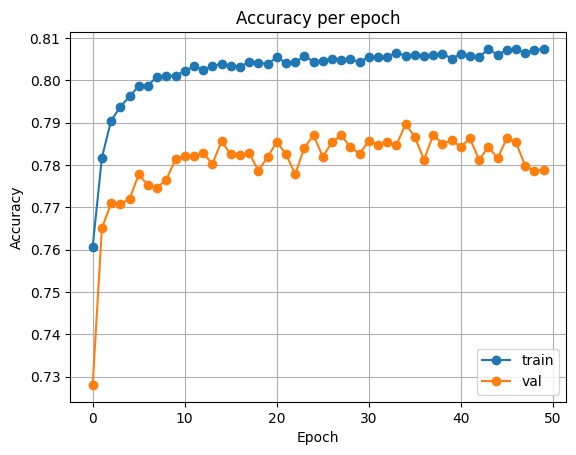

In [26]:
train.plot_acc(history=history)

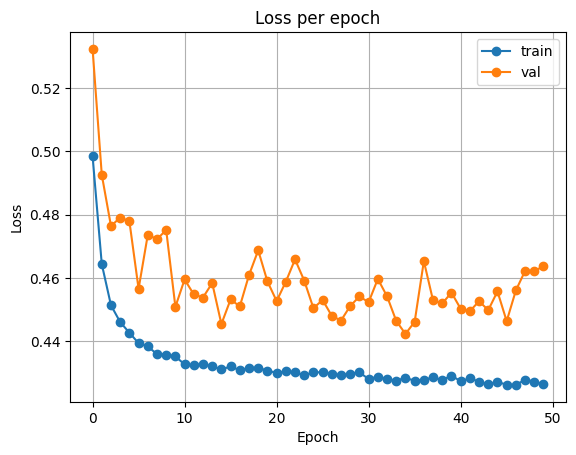

In [27]:
train.plot_loss(history=history)

In [28]:
backbone = VGG16.VGG16_Backbone(pretrain=False).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

model.load_state_dict(torch.load('Best_Model_VGG_3.pth', map_location=device))
model.eval()

test_loss, test_acc = train.model_evaluate(model=model,
                                           data_loader=test_loader,
                                           criterion=criterion,
                                           device=device)

print('Test Loss: %s'%test_loss)
print('Test Accuracy: %s'%test_acc)

Test Loss: 0.4493719134479761
Test Accuracy: 0.797760009765625


# ResNet

## SimCLR

In [3]:
path = './data'

dataset_simclr = data_aug.ContrastiveLearningDataset(path=path, input_shape=96)

batch_size = 256

train_set = dataset_simclr.get_dataset()
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=0,
                                           pin_memory=True, 
                                           drop_last=True)

In [4]:
backbone = ResNet34.ResNet34_Backbone(pretrain=False).to(device=device)
model = basic_simclr.BasicSimCLR(backbone, num_classes=64).to(device=device)

print(model)

BasicSimCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [5]:
# default hyperparameters
lr = 3e-4
weight_decay = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                       T_max=len(train_loader), 
                                                       eta_min=0,
                                                       last_epoch=-1)

In [6]:
simclr = simclr_train.SimCLR(model=model,
                             model_name='ResNet34',
                             scheduler=scheduler,
                             optimizer=optimizer,
                             device=device,
                             epochs=100)

In [7]:
simclr.train(train_loader=train_loader)

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [26:56<00:00,  1.58s/it]


## Model Train

In [29]:
# (already downloaded) dataset path 
path = './data'

train_loader, val_loader, test_loader = dataset.load_pcam(path=path, 
                                                          input_shape=96,
                                                          augmentation=True,
                                                          normalize=True,
                                                          batch_size=256,
                                                          seed=21)

In [30]:
backbone = ResNet34.ResNet34_Backbone(pretrain=False).to(device=device)
model_temp = basic_simclr.BasicSimCLR(backbone, num_classes=64).to(device=device)

# path - ResNet 
log_dir = 'checkpoints/Mar28_13-19-07'
file_path = 'checkpoint_0100.pth.tar'

checkpoint_path = os.path.join(log_dir, file_path)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_temp.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [31]:
# backbone from SimCLR
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

print(model)

BasicClassifier(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [32]:
EPOCHS = 50

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
es = train.EarlyStopping(patience=EPOCHS//2, delta=0, mode='min', verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=EPOCHS//5, gamma=0.9)

history = {'train_loss' : [],
           'val_loss': [],
           'train_accuracy': [],
           'val_accuracy': []}
           
max_loss = np.inf    

In [33]:
for epoch in range(EPOCHS):
    train_loss, train_acc = train.model_train(model=model, 
                                              data_loader=train_loader, 
                                              criterion=criterion, 
                                              optimizer=optimizer, 
                                              device=device, 
                                              scheduler=scheduler, 
                                              tqdm_disable=False)
    val_loss, val_acc = train.model_evaluate(model=model, 
                                             data_loader=val_loader, 
                                             criterion=criterion, 
                                             device=device)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    es(val_loss)
    # Early Stop Check
    if es.early_stop:
        break

    if val_loss < max_loss:
        print(f'[INFO] val_loss has been improved from {max_loss:.5f} to {val_loss:.5f}. Save model.')
        max_loss = val_loss
        torch.save(model.state_dict(), 'Best_Model_ResNet_3.pth')

    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, accuracy: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f} \n')

100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [08:10<00:00,  2.09it/s]


[EarlyStopping] (Update) Best Score: 0.44059
[INFO] val_loss has been improved from inf to 0.44059. Save model.
epoch 01, loss: 0.41694, accuracy: 0.81708, val_loss: 0.44059, val_accuracy: 0.79453 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [08:03<00:00,  2.12it/s]


[EarlyStopping] (Update) Best Score: 0.39524
[INFO] val_loss has been improved from 0.44059 to 0.39524. Save model.
epoch 02, loss: 0.37291, accuracy: 0.83658, val_loss: 0.39524, val_accuracy: 0.81760 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.39524, Current: 0.39567, Delta: 0.00043
epoch 03, loss: 0.36526, accuracy: 0.84076, val_loss: 0.39567, val_accuracy: 0.81638 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:59<00:00,  2.14it/s]


[EarlyStopping] (Update) Best Score: 0.38957
[INFO] val_loss has been improved from 0.39524 to 0.38957. Save model.
epoch 04, loss: 0.35956, accuracy: 0.84294, val_loss: 0.38957, val_accuracy: 0.82114 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.38957, Current: 0.39970, Delta: 0.01014
epoch 05, loss: 0.35670, accuracy: 0.84470, val_loss: 0.39970, val_accuracy: 0.81421 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.38957, Current: 0.40193, Delta: 0.01237
epoch 06, loss: 0.35476, accuracy: 0.84593, val_loss: 0.40193, val_accuracy: 0.81699 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:59<00:00,  2.14it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.38957, Current: 0.39280, Delta: 0.00323
epoch 07, loss: 0.35370, accuracy: 0.84573, val_loss: 0.39280, val_accuracy: 0.81985 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.38957, Current: 0.39273, Delta: 0.00316
epoch 08, loss: 0.35218, accuracy: 0.84705, val_loss: 0.39273, val_accuracy: 0.82233 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.38957, Current: 0.39338, Delta: 0.00381
epoch 09, loss: 0.35199, accuracy: 0.84732, val_loss: 0.39338, val_accuracy: 0.82098 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Update) Best Score: 0.38736
[INFO] val_loss has been improved from 0.38957 to 0.38736. Save model.
epoch 10, loss: 0.35167, accuracy: 0.84678, val_loss: 0.38736, val_accuracy: 0.82245 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Update) Best Score: 0.38111
[INFO] val_loss has been improved from 0.38736 to 0.38111. Save model.
epoch 11, loss: 0.35081, accuracy: 0.84756, val_loss: 0.38111, val_accuracy: 0.82629 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.14it/s]


[EarlyStopping] (Update) Best Score: 0.37753
[INFO] val_loss has been improved from 0.38111 to 0.37753. Save model.
epoch 12, loss: 0.35146, accuracy: 0.84829, val_loss: 0.37753, val_accuracy: 0.83066 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.37753, Current: 0.38248, Delta: 0.00494
epoch 13, loss: 0.34955, accuracy: 0.84877, val_loss: 0.38248, val_accuracy: 0.82544 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.37753, Current: 0.37960, Delta: 0.00207
epoch 14, loss: 0.34974, accuracy: 0.84890, val_loss: 0.37960, val_accuracy: 0.82751 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.37753, Current: 0.39545, Delta: 0.01792
epoch 15, loss: 0.34970, accuracy: 0.84832, val_loss: 0.39545, val_accuracy: 0.81766 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.37753, Current: 0.38917, Delta: 0.01164
epoch 16, loss: 0.35025, accuracy: 0.84809, val_loss: 0.38917, val_accuracy: 0.82306 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Update) Best Score: 0.37679
[INFO] val_loss has been improved from 0.37753 to 0.37679. Save model.
epoch 17, loss: 0.34999, accuracy: 0.84794, val_loss: 0.37679, val_accuracy: 0.82831 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Update) Best Score: 0.37353
[INFO] val_loss has been improved from 0.37679 to 0.37353. Save model.
epoch 18, loss: 0.35055, accuracy: 0.84829, val_loss: 0.37353, val_accuracy: 0.83121 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 1/25, Best: 0.37353, Current: 0.39830, Delta: 0.02477
epoch 19, loss: 0.35004, accuracy: 0.84909, val_loss: 0.39830, val_accuracy: 0.82053 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 2/25, Best: 0.37353, Current: 0.38286, Delta: 0.00933
epoch 20, loss: 0.34958, accuracy: 0.84855, val_loss: 0.38286, val_accuracy: 0.82715 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 3/25, Best: 0.37353, Current: 0.38677, Delta: 0.01324
epoch 21, loss: 0.34915, accuracy: 0.84922, val_loss: 0.38677, val_accuracy: 0.82547 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 4/25, Best: 0.37353, Current: 0.38272, Delta: 0.00919
epoch 22, loss: 0.34946, accuracy: 0.84875, val_loss: 0.38272, val_accuracy: 0.82620 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 5/25, Best: 0.37353, Current: 0.38752, Delta: 0.01399
epoch 23, loss: 0.34849, accuracy: 0.84905, val_loss: 0.38752, val_accuracy: 0.82361 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 6/25, Best: 0.37353, Current: 0.39387, Delta: 0.02034
epoch 24, loss: 0.34897, accuracy: 0.84931, val_loss: 0.39387, val_accuracy: 0.82050 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.14it/s]


[EarlyStopping] (Patience) 7/25, Best: 0.37353, Current: 0.38392, Delta: 0.01039
epoch 25, loss: 0.34886, accuracy: 0.84974, val_loss: 0.38392, val_accuracy: 0.82574 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 8/25, Best: 0.37353, Current: 0.38180, Delta: 0.00827
epoch 26, loss: 0.34791, accuracy: 0.85014, val_loss: 0.38180, val_accuracy: 0.82593 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.14it/s]


[EarlyStopping] (Patience) 9/25, Best: 0.37353, Current: 0.37726, Delta: 0.00373
epoch 27, loss: 0.34838, accuracy: 0.85062, val_loss: 0.37726, val_accuracy: 0.82764 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 10/25, Best: 0.37353, Current: 0.38695, Delta: 0.01342
epoch 28, loss: 0.34893, accuracy: 0.84951, val_loss: 0.38695, val_accuracy: 0.82336 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 11/25, Best: 0.37353, Current: 0.39373, Delta: 0.02020
epoch 29, loss: 0.34874, accuracy: 0.84916, val_loss: 0.39373, val_accuracy: 0.82120 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 12/25, Best: 0.37353, Current: 0.38807, Delta: 0.01454
epoch 30, loss: 0.34908, accuracy: 0.84933, val_loss: 0.38807, val_accuracy: 0.82416 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:59<00:00,  2.13it/s]


[EarlyStopping] (Patience) 13/25, Best: 0.37353, Current: 0.39102, Delta: 0.01749
epoch 31, loss: 0.34844, accuracy: 0.84938, val_loss: 0.39102, val_accuracy: 0.82413 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:56<00:00,  2.15it/s]


[EarlyStopping] (Patience) 14/25, Best: 0.37353, Current: 0.38420, Delta: 0.01068
epoch 32, loss: 0.34868, accuracy: 0.85059, val_loss: 0.38420, val_accuracy: 0.82526 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 15/25, Best: 0.37353, Current: 0.37683, Delta: 0.00330
epoch 33, loss: 0.34837, accuracy: 0.84929, val_loss: 0.37683, val_accuracy: 0.82715 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:59<00:00,  2.13it/s]


[EarlyStopping] (Patience) 16/25, Best: 0.37353, Current: 0.38546, Delta: 0.01194
epoch 34, loss: 0.34710, accuracy: 0.85009, val_loss: 0.38546, val_accuracy: 0.82516 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.14it/s]


[EarlyStopping] (Patience) 17/25, Best: 0.37353, Current: 0.38591, Delta: 0.01238
epoch 35, loss: 0.34794, accuracy: 0.84975, val_loss: 0.38591, val_accuracy: 0.82535 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 18/25, Best: 0.37353, Current: 0.37757, Delta: 0.00405
epoch 36, loss: 0.34804, accuracy: 0.84965, val_loss: 0.37757, val_accuracy: 0.82794 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.15it/s]


[EarlyStopping] (Patience) 19/25, Best: 0.37353, Current: 0.38786, Delta: 0.01433
epoch 37, loss: 0.34917, accuracy: 0.84906, val_loss: 0.38786, val_accuracy: 0.82507 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 20/25, Best: 0.37353, Current: 0.39245, Delta: 0.01892
epoch 38, loss: 0.34770, accuracy: 0.84990, val_loss: 0.39245, val_accuracy: 0.82147 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 21/25, Best: 0.37353, Current: 0.38557, Delta: 0.01204
epoch 39, loss: 0.34820, accuracy: 0.84942, val_loss: 0.38557, val_accuracy: 0.82361 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 22/25, Best: 0.37353, Current: 0.38744, Delta: 0.01391
epoch 40, loss: 0.34814, accuracy: 0.84971, val_loss: 0.38744, val_accuracy: 0.82419 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 23/25, Best: 0.37353, Current: 0.39137, Delta: 0.01784
epoch 41, loss: 0.34734, accuracy: 0.85035, val_loss: 0.39137, val_accuracy: 0.82220 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:58<00:00,  2.14it/s]


[EarlyStopping] (Patience) 24/25, Best: 0.37353, Current: 0.38554, Delta: 0.01202
epoch 42, loss: 0.34815, accuracy: 0.84999, val_loss: 0.38554, val_accuracy: 0.82541 



100%|███████████████████████████████████████████████████████████████████████████| 1024/1024 [07:57<00:00,  2.14it/s]


[EarlyStopping] (Patience) 25/25, Best: 0.37353, Current: 0.38163, Delta: 0.00810
[EarlyStop Triggered] Best Score: 0.37353


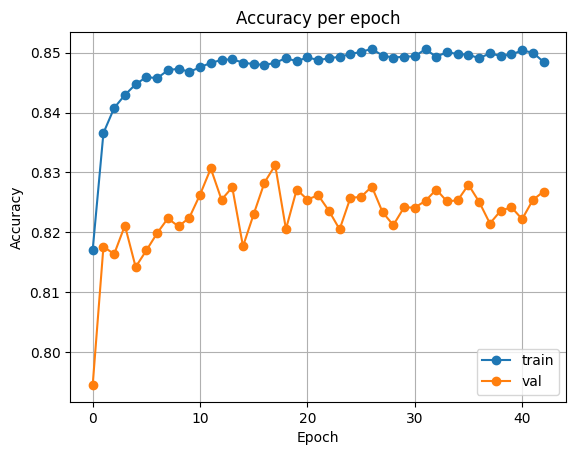

In [34]:
train.plot_acc(history=history)

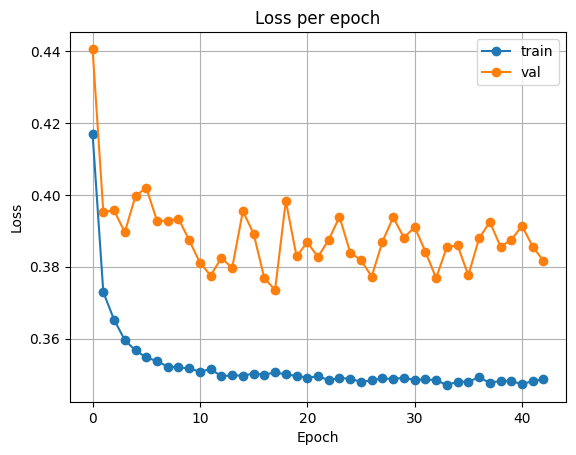

In [35]:
train.plot_loss(history=history)

In [37]:
backbone = ResNet34.ResNet34_Backbone(pretrain=False).to(device=device)
model = basic_classifier.BasicClassifier(backbone=backbone, 
                                         freezing=True, 
                                         num_classes=1).to(device=device)

model.load_state_dict(torch.load('Best_Model_ResNet_3.pth', map_location=device))
model.eval()

test_loss, test_acc = train.model_evaluate(model=model,
                                           data_loader=test_loader,
                                           criterion=criterion,
                                           device=device)

print('Test Loss: %s'%test_loss)
print('Test Accuracy: %s'%test_acc)

Test Loss: 0.40419348631985486
Test Accuracy: 0.815521240234375
